# CustomLSTM: Inspecting LSTM States and Activations

**Before we start**

- This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you want to run the code yourself, you can find the notebook and configuration files [here](https://github.com/neuralhydrology/neuralhydrology/tree/master/examples/05-Inspecting-LSTMs).
- To be able to run this notebook locally, you need to download the publicly available CAMELS US rainfall-runoff dataset. See the [Data Prerequisites Tutorial](data-prerequisites.nblink) for a detailed description on where to download the data and how to structure your local dataset folder.

This tutorial shows how to use `CustomLSTM` to inspect the states and activations of a trained LSTM.
In previous publications, we have seen that the internals of LSTM seem to resemble physically meaningful quantities. For instance, [this publication](https://link.springer.com/chapter/10.1007/978-3-030-28954-6_19) found cells that are highly correlated to snow water equivalent (SWE), even though the LSTM had never seen SWE data during training.
While `CudaLSTM` is great for fast training of models, it limits the insights we can draw from model internals such as states and activations.
This is where `CustomLSTM` comes into play: `CustomLSTM` is another LSTM implementation that is much slower but that can return much more information on cell/hidden states and activations.

To train an LSTM model, you'll always want to use `CudaLSTM` since it makes use of PyTorch's pre-implemented LSTM with all its optimizations. Therefore, it's way faster than anything we could build ourselves.
Since `CustomLSTM` is slower than `CudaLSTM`, the usual workflow is: 

1. train a `CudaLSTM`
2. copy the `CudaLSTM` weights into a `CustomLSTM`
3. analyze the states/activations in the `CustomLSTM`

In [1]:
from pathlib import Path
from typing import Dict

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader

from neuralhydrology.datasetzoo import get_dataset, camelsus
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.modelzoo.customlstm import CustomLSTM
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

To start, let's train a "normal" LSTM (i.e., a `CudaLSTM`), just like we did in the introduction tutorial. (Again, for quick results, we train the model on a single basin. If you actually care about good predictions, don't do this. Train one model on lots of basins combined.). 


**Note**

- The config file assumes that the CAMELS US dataset is stored under `data/CAMELS_US` (relative to the main directory of this repository) or a symbolic link exists at this location. Make sure that this folder contains the required subdirectories `basin_mean_forcing`, `usgs_streamflow` and `camels_attributes_v2.0`. If your data is stored at a different location and you can't or don't want to create a symbolic link, you will need to change the `data_dir` argument in the `1_basin.yml` config file that is located in the same directory as this notebook.
- By default, the config (`1_basin.yml`) assumes that you have a CUDA-capable NVIDIA GPU (see config argument `device`). In case you don't have any or you have one but want to train on the CPU, you can either change the config argument to `device: cpu` or pass `gpu=-1` to the `start_run()` function.
- If you want to train on MacOS devices with Metal programming framework which enables high-performance training on GPU for MacOS, change the config argument to `device: mps` and don't pass the `gpu` argument to the `start_run()` function.

In [2]:
config_file = Path("1_basin.yml")
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=config_file)

# fall back to CPU-only mode
else:
    start_run(config_file=config_file, gpu=-1)

2022-01-05 22:10:39,141: Logging to /home/frederik/Projects/neuralhydrology/examples/05-Inspecting-LSTMs/runs/test_run_0501_221039/output.log initialized.
2022-01-05 22:10:39,141: ### Folder structure created at /home/frederik/Projects/neuralhydrology/examples/05-Inspecting-LSTMs/runs/test_run_0501_221039
2022-01-05 22:10:39,141: ### Run configurations for test_run
2022-01-05 22:10:39,142: experiment_name: test_run
2022-01-05 22:10:39,142: train_basin_file: 1_basin.txt
2022-01-05 22:10:39,142: validation_basin_file: 1_basin.txt
2022-01-05 22:10:39,143: test_basin_file: 1_basin.txt
2022-01-05 22:10:39,143: train_start_date: 1999-10-01 00:00:00
2022-01-05 22:10:39,144: train_end_date: 2008-09-30 00:00:00
2022-01-05 22:10:39,144: validation_start_date: 1980-10-01 00:00:00
2022-01-05 22:10:39,144: validation_end_date: 1989-09-30 00:00:00
2022-01-05 22:10:39,145: test_start_date: 1989-10-01 00:00:00
2022-01-05 22:10:39,145: test_end_date: 1999-09-30 00:00:00
2022-01-05 22:10:39,145: device:

Since the config we used for training has `save_weights_every` set to 1, we now have the weights of the model for every epoch in the run directory. Since the name of the run directory is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name.

In [3]:
run_dir = Path('runs/test_run_0501_221039')  # this value comes from the output of the above command
!ls $run_dir/model_epoch* | tail -n 3

runs/test_run_0501_221039/model_epoch028.pt
runs/test_run_0501_221039/model_epoch029.pt
runs/test_run_0501_221039/model_epoch030.pt


Next, we'll go ahead and load the final model (from epoch 30), so we can inspect its states and activations in more detail.
To do so, we first have to create a new CudaLSTM instance that we can then populate with the saved weights.

Small gotcha along the way: Make sure to set `map_location` to the device that you want to use for the loaded model. E.g., if you trained the above model on a GPU but want to do the subsequent weights analysis on CPU, you need to set `map_location='cpu'` so that the weights are loaded properly. Without this argument, you'll run into errors if you load a GPU model on a CPU.

In [4]:
cudalstm_config = Config(config_file)

# create a new model instance with random weights
cuda_lstm = CudaLSTM(cfg=cudalstm_config)

# load the trained weights into the new model. 
model_path = run_dir / 'model_epoch030.pt'
model_weights = torch.load(str(model_path), map_location='cpu')  # load the weights from the file, creating the weight tensors on CPU
cuda_lstm.load_state_dict(model_weights)  # set the new model's weights to the values loaded from file
cuda_lstm

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(5, 20)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)

We can use the same config to create our `CustomLSTM` and then use the method `.copy_weights()` to copy the weights of the trained `CudaLSTM` into the `CustomLSTM`:

In [5]:
custom_lstm = CustomLSTM(cfg=cudalstm_config)  # create a new CustomLSTM (with random weights)
custom_lstm.copy_weights(cuda_lstm)  # copy the CudaLSTM weights into the CustomLSTM
custom_lstm

CustomLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (cell): _LSTMCell()
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)

Now we have two models: The `CudaLSTM` that we trained in the beginning, and a `CustomLSTM` that has the exact same weights.
Just to check, let's compare some of the weights:

In [6]:
torch.allclose(cuda_lstm.lstm.bias_ih_l0, custom_lstm.cell.b_ih)

True

In [7]:
# make sure we're in eval mode where dropout is deactivated
custom_lstm.eval()
cuda_lstm.eval()

# load the dataset
scaler = load_scaler(run_dir)
dataset = get_dataset(cudalstm_config, is_train=False, period='test', scaler=scaler)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=False, collate_fn=dataset.collate_fn)

cudalstm_output = []
customlstm_output = []
# no need to calculate any gradients since we're just running some evaluations
with torch.no_grad():
    for sample in dataloader:
        customlstm_output.append(custom_lstm(sample))
        cudalstm_output.append(cuda_lstm(sample))

print('CudaLSTM output:  ', list(cudalstm_output[0].keys()))
print('CustomLSTM output:', list(customlstm_output[0].keys()))

# check if predictions of CustomLSTM and CudaLSTM are identical
print('Identical predictions:', torch.allclose(customlstm_output[0]['y_hat'], cudalstm_output[0]['y_hat'], atol=1e-5))

CudaLSTM output:   ['lstm_output', 'h_n', 'c_n', 'y_hat']
CustomLSTM output: ['h_n', 'c_n', 'i', 'f', 'g', 'o', 'y_hat']
Identical predictions: True


As we can see, the predictions of `CudaLSTM` and `CustomLSTM` are identical (up to a small tolerance). This makes sense, since we already know the models have the same weights.

But we can also see that the `CustomLSTM` returns more than just the predictions in `y_hat`! There's also:

| key | value |
|:----|:-------|
| `y_hat` | prediction |
| `c_n` | cell state |
| `h_n` | hidden state |
| `i` | input gate activation |
| `g` | cell input activation |
| `f` | forget gate activation |
| `o` | output gate activation |

`CudaLSTM` has an additional `lstm_output` key, but that is identical to the sequence of hidden states `h_n`.

While `CudaLSTM` retuns `c_n` and `h_n`, too, its tensors only contain the state at the last time step of each sample. `CustomLSTM` on the other hand returns the states for the full input sequence:

In [8]:
print('CudaLSTM shape:  ', cudalstm_output[0]['c_n'].shape)  # [batch size, 1, hidden size]
print('CustomLSTM shape:', customlstm_output[0]['c_n'].shape)  # [batch size, sequence length, hidden size]

CudaLSTM shape:   torch.Size([1000, 1, 20])
CustomLSTM shape: torch.Size([1000, 365, 20])


Now, let's take a closer look at the LSTM states and activations, look at how they evolve over time, and how this evolution correlates with input variables.
For instance, cell state 7 quite closely follows the time series of temperature:

In [9]:
# Concatenate all batches into one tensor that contains the final time step of each sample.
cell_states = torch.cat([out['c_n'][:, -1, :] for out in customlstm_output], dim=0)

# Load the forcings input for the corresponding date range
date_range = pd.date_range(cudalstm_config.test_start_date, cudalstm_config.test_end_date, freq='1D')
forcings = camelsus.load_camels_us_forcings(cudalstm_config.data_dir, '01022500', 'daymet')[0].loc[date_range]

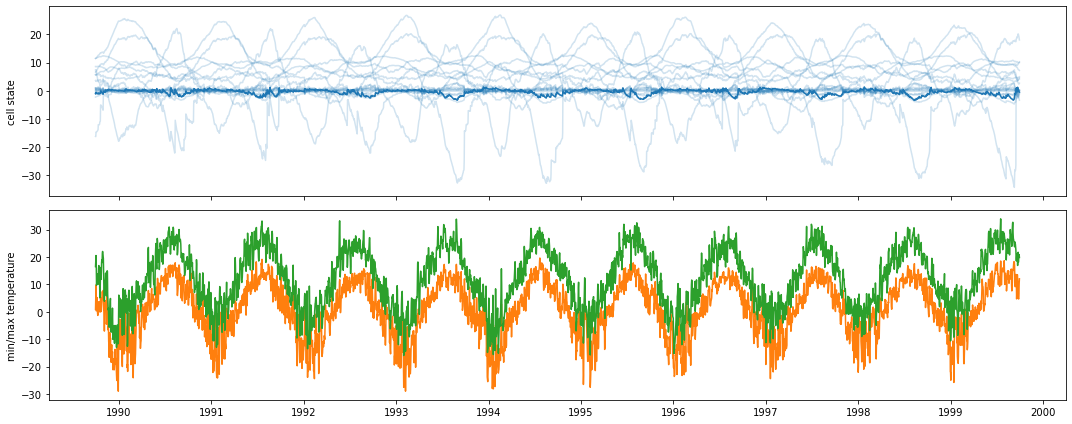

In [10]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax.plot(date_range, cell_states, c='C0', alpha=.2)
ax.plot(date_range, cell_states[:, 7], c='C0')

ax.set_ylabel('cell state')
ax2.set_ylabel('min/max temperature')

ax2.plot(date_range, forcings['tmin(C)'], c='C1')
ax2.plot(date_range, forcings['tmax(C)'], c='C2')
plt.tight_layout()

Finally, let's look at how the cell and hidden states and the gate activations develop while the LSTM processes the input sequence of a single sample:

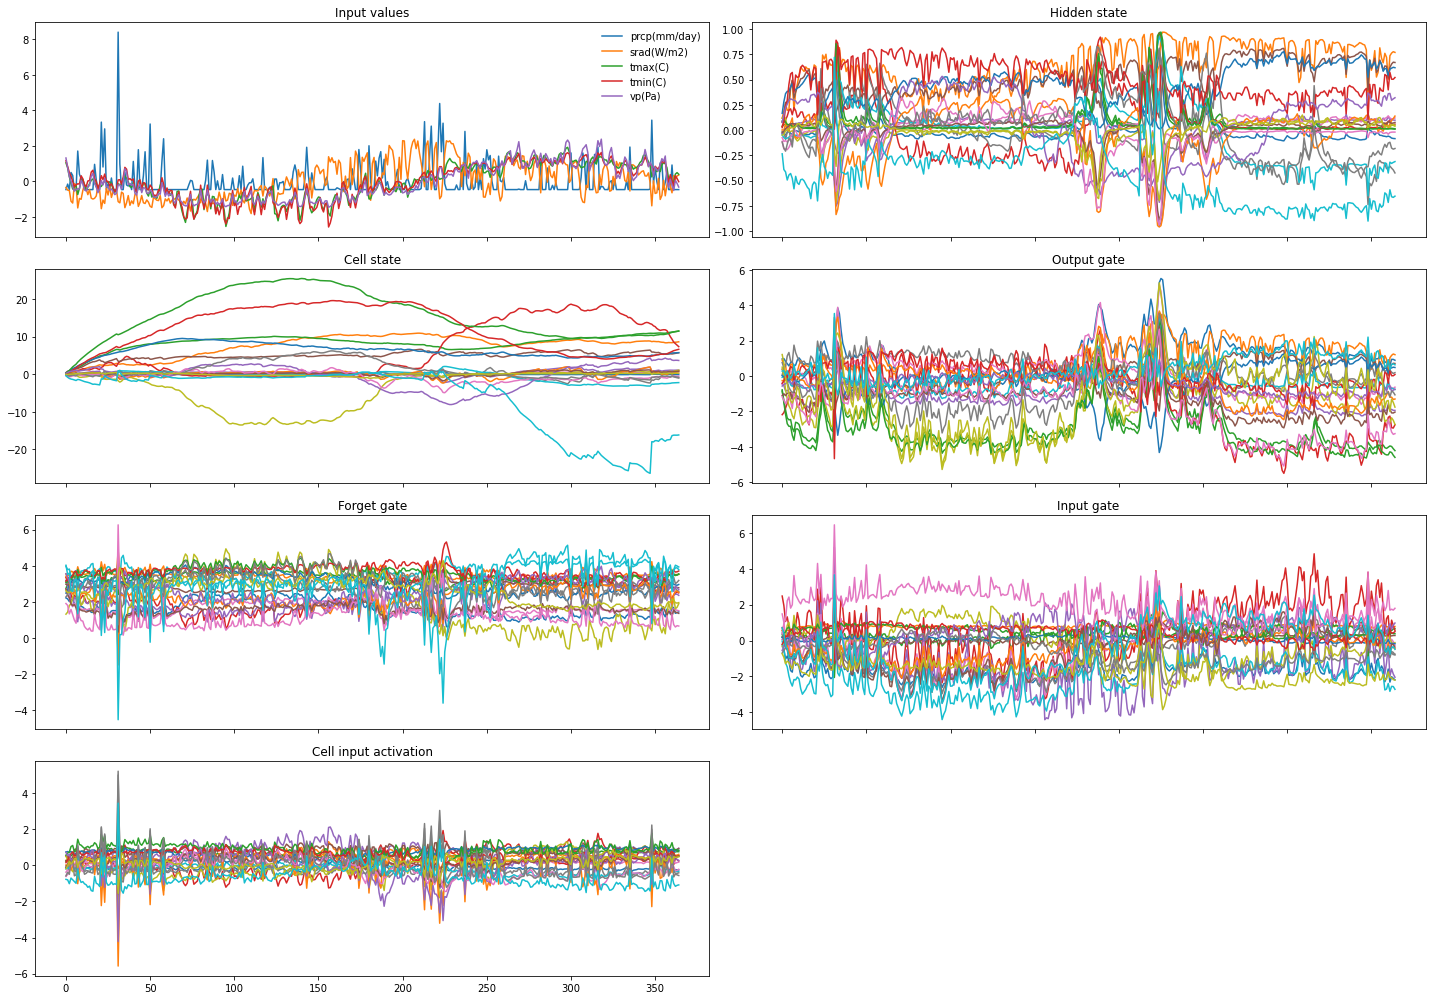

In [11]:
f, ax = plt.subplots(4, 2, figsize=(20, 14), sharex=True)
ax[0,0].set_title('Input values')
lines = ax[0,0].plot(dataset[0]['x_d'])  # these are the normalized inputs we fed the LSTM above
ax[0,0].legend(lines, cudalstm_config.dynamic_inputs, frameon=False)

ax[1,0].set_title('Cell state')
ax[1,0].plot(customlstm_output[0]['c_n'][0])

ax[0,1].set_title('Hidden state')
ax[0,1].plot(customlstm_output[0]['h_n'][0])

ax[1,1].set_title('Output gate')
ax[1,1].plot(customlstm_output[0]['o'][0])

ax[2,0].set_title('Forget gate')
ax[2,0].plot(customlstm_output[0]['f'][0])

ax[2,1].set_title('Input gate')
ax[2,1].plot(customlstm_output[0]['i'][0])

ax[3,0].set_title('Cell input activation')
ax[3,0].plot(customlstm_output[0]['g'][0])

f.delaxes(ax[3,1])
plt.tight_layout()

These plots show some interesting characteristics: e.g., the cell states start to behave differently around step 210, and the gates show noticeable activity also around steps 25 and 220 which nicely coincides with high-precipitation events.

That's it for this tutorial. The verbosity of `CustomLSTM`'s output gives you lots of options, and we'll leave it to your imagination as to how you want to analyze the LSTM states and activations. For instance, search for states (or combinations thereof) that correspond to physically meaningful variables, or analyze patterns in the gates' activations.